# Defaultable Bond Model

In this note, I will introduce an application of simulation in the defaultable bond model. Assume we have two CIR process
$$d r^{(i)} = a_i(b_i-r^{(i)})d t + \sigma_i \sqrt{r^{(i)}}d W_t^{(i)}$$
where $W^{(i)}$ are independent.

Now assume we have a bond with the interest rate $r$, 
$$r = r^{(1)}$$
And this bond is defaultable with default time $\tau$; and $\lambda$ is the intensity for $1_{\{ \tau<t \}}$. Assume 
$$\lambda = \sqrt{c} r^{(1)} + \sqrt{1-c}r^{(2)}$$

## Main Problem: Pricing the defaultable bond

Notice that under our setting, **the default time is related to the interest rate.** 

In [49]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mc_generator import *

## Pricing the simplest case 

First, we assume the bond will not be defaulted. Because it is a CIR process, its price can be computed explicitly (see [here](https://en.wikipedia.org/wiki/Cox%E2%80%93Ingersoll%E2%80%93Ross_model#Bond_pricing))

Now we want to compare the theoritical result and the simulation result.

In [50]:
# Theoritical solution
def _h(t, T, a, b, sigma):
    return np.sqrt( a**2 + 2* sigma**2 )

def _A(t, T, a, b, sigma):
    h = _h( t, T, a, b, sigma )
    numerator = 2* h * np.exp( (a+h)*(T-t)/2 )
    denominator = 2*h+(a+h)*( np.exp((T-t)*h) - 1 )
    power = 2*a*b/(sigma**2)
    return (numerator/denominator)**power

def _B(t, T, a, b, sigma):
    h = _h( t, T, a, b, sigma )
    numerator = 2*( np.exp((T-t)/h) - 1 )
    denominator = 2*h+(a+h)*( np.exp((T-t)/h) - 1 )
    return numerator/denominator

def price_at_t(r_t, t, T, a, b, sigma):
    A = _A(t, T, a, b, sigma)
    B = _B(t, T, a, b, sigma)
    return A*np.exp(-B*r_t)

def _price(T, a, b, sigma):
    A = _A(0, T, a, b, sigma)
    B = _B(0, T, a, b, sigma)
    return A*np.exp(-B)

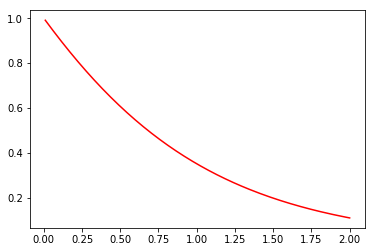

In [51]:
num_trails = 150

#Plot the price of bond with CIR interest rate
a = 1.0
b = 1.2
sigma = 0.2
T = 2.0

time = np.linspace(0.01,T,num_trails)
p_th = [] 
for maturity in time:
    #compute the price of bond at time 0 
    p_th.append( _price(maturity, a, b, sigma))
    
plt.plot(time,p_th,'r')

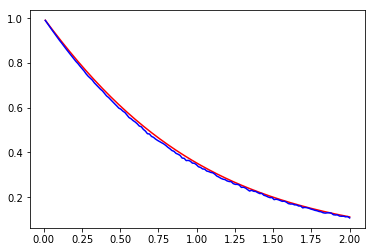

In [59]:
# Simulation result - Monte Carlo simulation

# Define the time change A_t
def A(t, intensity):
    time = 0
    A_t = 0
    for s,lambda_s in zip(intensity.time, intensity.simulation):
        A_t += lambda_s * (s - time)
        time = s
        if time > t:
            break
    return A_t


def price(T, lambda_, a, b, sigma, num_trails = num_trails):
    sum_of_simulation = 0
    for n in range(num_trails):
        #simulate r_s
        r = CIR(a, b, sigma, 1)
        r.simulate(num_trails=num_trails, start_time=0.0, end_time=T)
        #compute e^{-\lambda \int^T_0 r_s ds}
        sum_of_simulation += np.exp( -lambda_ * A(T, r) )
    price = sum_of_simulation/num_trails 
    return price

T = 2
time = np.linspace(0.01,T,num_trails)
lambda_ =  1
p = []
for t in time:
    p.append(price(t, lambda_, a, b, sigma) )
plt.plot( time, p_th, 'r' )
plt.plot( time, p, 'b' )

With num_trails=150, the simulation result is very closed to the true result. And if we increse the num_trails, the graph will be much nicer.   

# Pricing Defaultable Bond

Now we assume the bond is defaultable. The theoritical price could be computed using the following code: 

In [64]:
def change_parameters(c, a,b, sigma):
    return a, c*b, sigma/np.sqrt(c)
 
def price_d(T, a, b, sigma, c):
    a1,b1,sigma1 = change_parameters(np.sqrt(1-c), a,b, sigma)
    p1 = _price(T, a1, b1, sigma1)
    
    a2,b2,sigma2 = change_parameters(np.sqrt(c)+1, a,b, sigma)
    p2 = _price(T, a2, b2, sigma2)
    
    return p1*p2

def price_sim(T, a, b, sigma, c, num_trails): 
    return price(T, np.sqrt(1-c), a, b, sigma, num_trails) *  price(T, np.sqrt(c)+1, a, b, sigma, num_trails)

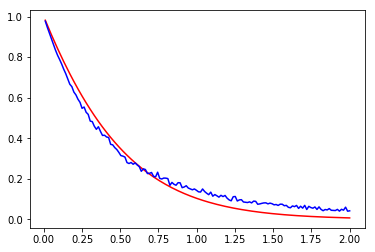

In [65]:
c = 0.5
p_the = []
p_sim = []
for t in time:
    p_the.append(price_d(t, a, b, sigma, c) )
    p_sim.append(price_sim(t, c, a, b, sigma, num_trails) )
plt.plot( time, p_the, 'r' )
plt.plot( time, p_sim, 'b' )